We connect to google drive where the dataset has been stored

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries
We import the libraries that we are going to use

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten, Dense
from keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda
from keras.models import Model
import keras
import tensorflow as tf
from keras.optimizers import Adam
from keras.utils import plot_model
import seaborn as sns
from keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from numpy.random import randn
import os
import functools
import tensorflow_datasets as tfds
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/FID/')  # Append the directory containing fid.py

import fid  # Now fid.py should be importable

# Dataset

The dataset was uploaded to Google Drive and subsequently imported. Using np.load, the images were then stored in the variable named "img."

In [4]:
file_name = "/content/drive/MyDrive/VAE Dataset/sh3_sc6_y32_x32_imgs.npz"
imgs = np.load(file_name, allow_pickle=True, encoding='latin1')
imgs = imgs['imgs']

To gain a deeper understanding of the dataset, 10 randomly selected images were plotted to provide a visual insight into its content.

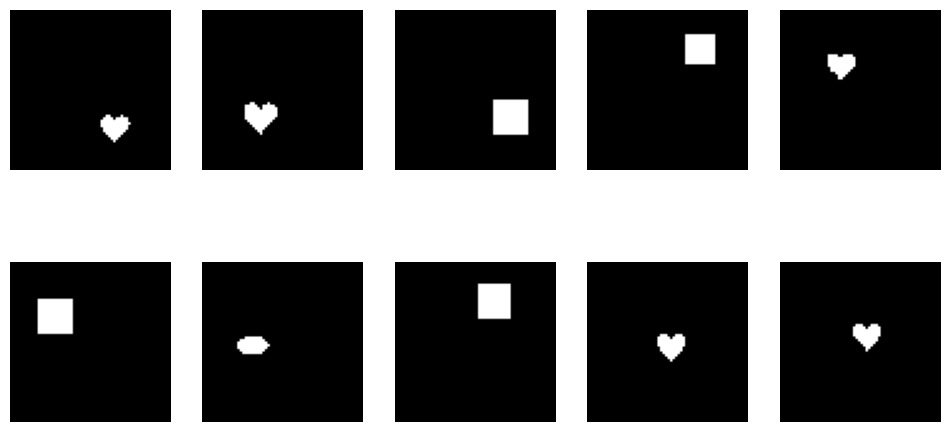

In [5]:
# Get 10 random indices
random_indices = random.sample(range(len(imgs)), 10)

# Plot the randomly selected 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]
    ax.imshow(imgs[idx], cmap='gray')
    ax.axis('off')

plt.show()

In [6]:
latent_dim = 10 # Number of latent dim parameters

input_shape = (64, 64, 1)

input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, (4, 4), activation='relu', strides=2, padding='same')(input_img)
x = Conv2D(32, (4, 4), activation='relu', strides=2, padding='same')(x)
x = Conv2D(64, (4, 4), activation='relu', strides=2, padding='same')(x)
x = Conv2D(64, (4, 4), activation='relu', strides=2, padding='same')(x)
x = Conv2D(256, (4, 4), activation='relu', padding='same')(x)

#Flatten
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(20, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Reparameterization
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], tf.shape(z_mean)[1]))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [7]:
encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           544       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 32)           16416     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 8, 8, 64)             32832     ['conv2d_1[0][0]']            
                                                                                            

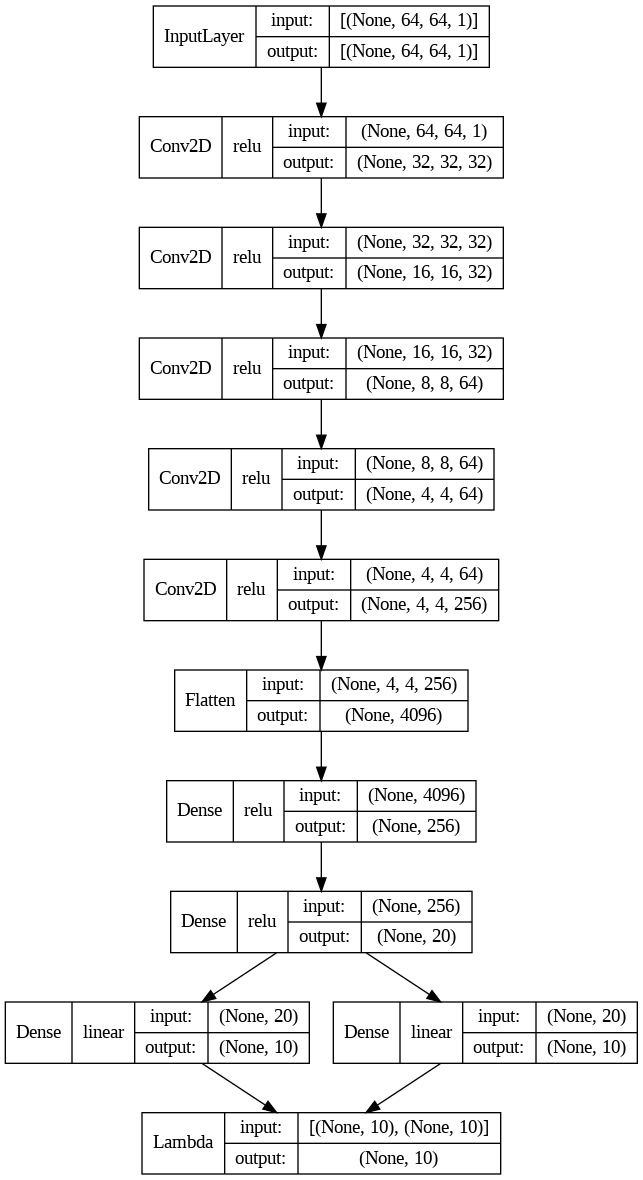

In [8]:
plot_model(encoder, to_file='model_plot.png', show_shapes=True, show_layer_names=False, show_layer_activations=True)

In [9]:
# Decoder
decoder_input = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(256, activation='relu')(decoder_input)
x = Reshape((4, 4, 16))(x)  # For the decoder output to be the same size as the encoder input
x = Conv2DTranspose(256, (4, 4), activation='relu', strides=1, padding='same')(x)
x = Conv2DTranspose(64, (4, 4), activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(64, (4, 4), activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, (4, 4), activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, (4, 4), activation='relu', strides=2, padding='same')(x)
decoded = Conv2DTranspose(1, (4, 4), activation='sigmoid', padding='same', name='decoder_output')(x)

In [10]:
decoder = Model(decoder_input, decoded, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2816      
                                                                 
 reshape (Reshape)           (None, 4, 4, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 256)         65792     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 64)          262208    
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 16, 16, 64)        6560

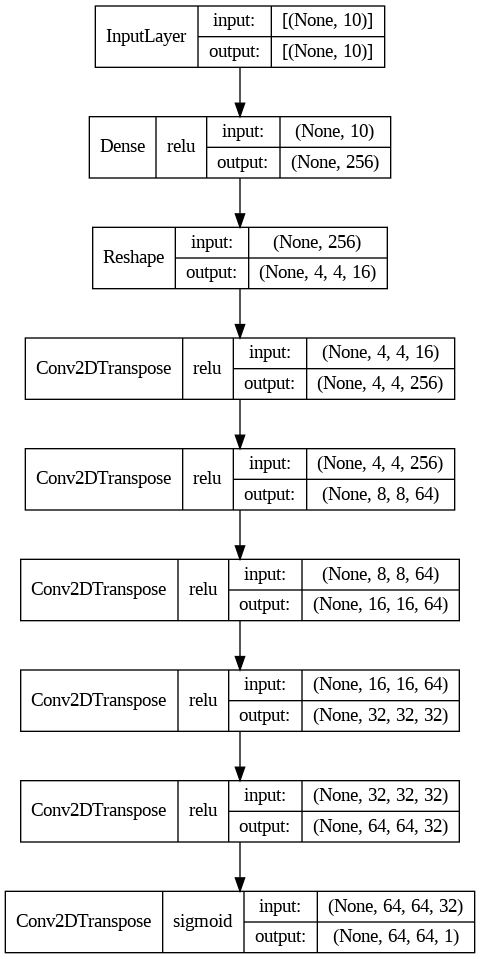

In [11]:
plot_model(decoder, to_file='model_plot.png', show_shapes=True, show_layer_names=False, show_layer_activations=True)

In [12]:
imgs.shape

(18432, 64, 64)

To fit in the model

In [13]:
data = np.expand_dims(imgs, axis=-1)

In [14]:
data.shape

(18432, 64, 64, 1)

In [51]:
def calculate_fid(real_images, generated_images):
    # Load pre-trained InceptionV3 model
    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Convert images to numpy arrays
    real_images = np.array(real_images)
    generated_images = np.array(generated_images)

    # Preprocess images for Inception-v3 model
    real_images = preprocess_input(real_images)
    generated_images = preprocess_input(generated_images)

    # Get features from Inception-v3 model
    real_features = inception_model.predict(real_images)
    generated_features = inception_model.predict(generated_images)

    # Calculate mean and covariance statistics for real and generated features
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_generated, sigma_generated = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    # Compute the Frobenius norm of the difference between covariances
    cov_sqrt = np.linalg.cholesky(sigma_real.dot(sigma_generated))

    # Compute the trace of the product of covariance matrices
    trace = np.trace(sigma_real + sigma_generated - 2*cov_sqrt)

    # Compute the squared Frobenius norm between the means
    mean_diff = np.sum((mu_real - mu_generated)**2)

    # Compute the Frechet distance
    fid_score = mean_diff + trace

    return fid_score

In [16]:
# Define a custom callback
class LossHistory(keras.callbacks.Callback):
    def __init__(self):
        self.kl_losses = []
        self.reconstruction_losses = []
        self.total_losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.kl_losses.append(logs['kl_loss'])
        self.reconstruction_losses.append(logs['reconstruction_loss'])
        self.total_losses.append(logs['loss'])

In [17]:
class VAE(keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__(**kwargs)

        # encoder
        self.encoder = tf.keras.Sequential([
            Input(shape=input_shape),
            Conv2D(32, (4, 4), activation='relu', strides=2, padding='same'),
            Conv2D(32, (4, 4), activation='relu', strides=2, padding='same'),
            Conv2D(64, (4, 4), activation='relu', strides=2, padding='same'),
            Conv2D(64, (4, 4), activation='relu', strides=2, padding='same'),
            Conv2D(256, (4, 4), activation='relu', padding='same'),
            Flatten(),
            Dense(256, activation="relu"),
            Dense(20, activation="relu"),
            Dense(latent_dim),
        ])

        # reparameterization/sampling layer
        self.z_mean = Dense(latent_dim, name="z_mean")
        self.z_log_var = Dense(latent_dim, name="z_log_var")

        # decoder
        self.decoder = tf.keras.Sequential([
          Input(shape=(latent_dim,)),
          Dense(256, activation='relu'),
          Reshape((4, 4, 16)),  # For the decoder output to be the same size as the encoder input
          Conv2DTranspose(256, (4, 4), activation='relu', strides=1, padding='same'),
          Conv2DTranspose(64, (4, 4), activation='relu', strides=2, padding='same'),
          Conv2DTranspose(64, (4, 4), activation='relu', strides=2, padding='same'),
          Conv2DTranspose(32, (4, 4), activation='relu', strides=2, padding='same'),
          Conv2DTranspose(32, (4, 4), activation='relu', strides=2, padding='same'),
          Conv2DTranspose(1, (4, 4), activation='sigmoid', padding='same', name='decoder_output')
        ])

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    # Build the encoder
    def encode(self, data):
        x = self.encoder(data)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        return z_mean, z_log_var

    # Build the reparameterization/sampling layer
    def reparameterization(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z =  z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z

    # Build the decoder
    def decode(self, data):
        return self.decoder(data)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encode(data)
            z = self.reparameterization(z_mean, z_log_var)
            reconstruction = self.decode(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [18]:
# Train the VAE
vae = VAE()
# Define the learning rate
learning_rate = 0.0001

# Compile the VAE model with the Adam optimizer and the specified learning rate
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))

In [20]:
history_1 = LossHistory()
vae.fit(data, epochs=50, batch_size=32, callbacks=[history_1])

Epoch 1/50
576/576 [==============================] - 9s 16ms/step - loss: 95.4672 - reconstruction_loss: 68.3180 - kl_loss: 25.4198
Epoch 2/50
576/576 [==============================] - 7s 12ms/step - loss: 89.6345 - reconstruction_loss: 62.3524 - kl_loss: 25.7211
Epoch 3/50
576/576 [==============================] - 7s 13ms/step - loss: 84.8882 - reconstruction_loss: 58.6373 - kl_loss: 25.6615
Epoch 4/50
576/576 [==============================] - 6s 10ms/step - loss: 81.3659 - reconstruction_loss: 55.4243 - kl_loss: 25.6034
Epoch 5/50
576/576 [==============================] - 6s 10ms/step - loss: 80.0362 - reconstruction_loss: 54.0983 - kl_loss: 25.4911
Epoch 6/50
576/576 [==============================] - 6s 10ms/step - loss: 77.6429 - reconstruction_loss: 51.6821 - kl_loss: 25.4225
Epoch 7/50
576/576 [==============================] - 6s 11ms/step - loss: 75.8570 - reconstruction_loss: 49.7300 - kl_loss: 25.3880
Epoch 8/50
576/576 [==============================] - 6s 10ms/step - 

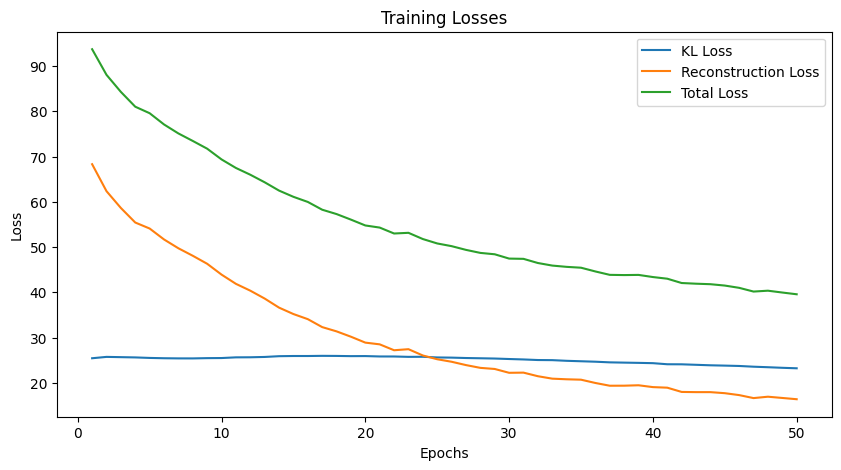

In [21]:
# Plot losses
epochs_range = range(1, 51)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, history_1.kl_losses, label='KL Loss')
plt.plot(epochs_range, history_1.reconstruction_losses, label='Reconstruction Loss')
plt.plot(epochs_range, history_1.total_losses, label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

In [22]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [23]:
# scale an array of images to a new size
def scale_images(images, new_shape):
 images_list = list()
 for image in images:
    # resize with nearest neighbor interpolation
    new_image = resize(image, new_shape, 0)
    # store
    images_list.append(new_image)
 return asarray(images_list)

In [24]:
# Select a subset of 6000 real images from your data
test_real_images = data[:6000]

In [25]:
# Generate 6000 images using your VAE model
latent_points = generate_latent_points(10, 6000)
# generate images
generated_images = vae.decoder.predict(latent_points)

32/32 [==============================] - 1s 10ms/step


In [26]:
# Scale generated images to the required input shape (299, 299, 3) for InceptionV3
scaled_generated_images = scale_images(generated_images, (299, 299, 3))

# Scale real images to the same shape
scaled_real_images = scale_images(test_real_images, (299, 299, 3))

In [27]:
# Calculate FID score
fid_score = calculate_fid(scaled_real_images, scaled_generated_images)
print("FID Score:", fid_score)

32/32 [==============================] - 4s 118ms/step
FID Score: 81.22552440506611


In [28]:
def save_plot(examples, w, h):
    plt.figure(figsize=(15, 15))  # Set the size of the figure
    # Plot images
    for i in range(w * h):
        # Define subplot
        plt.subplot(w, h, 1 + i)
        # Turn off axis
        plt.axis('off')
        # Plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray')
    plt.show()

2/2 [==============================] - 0s 283ms/step


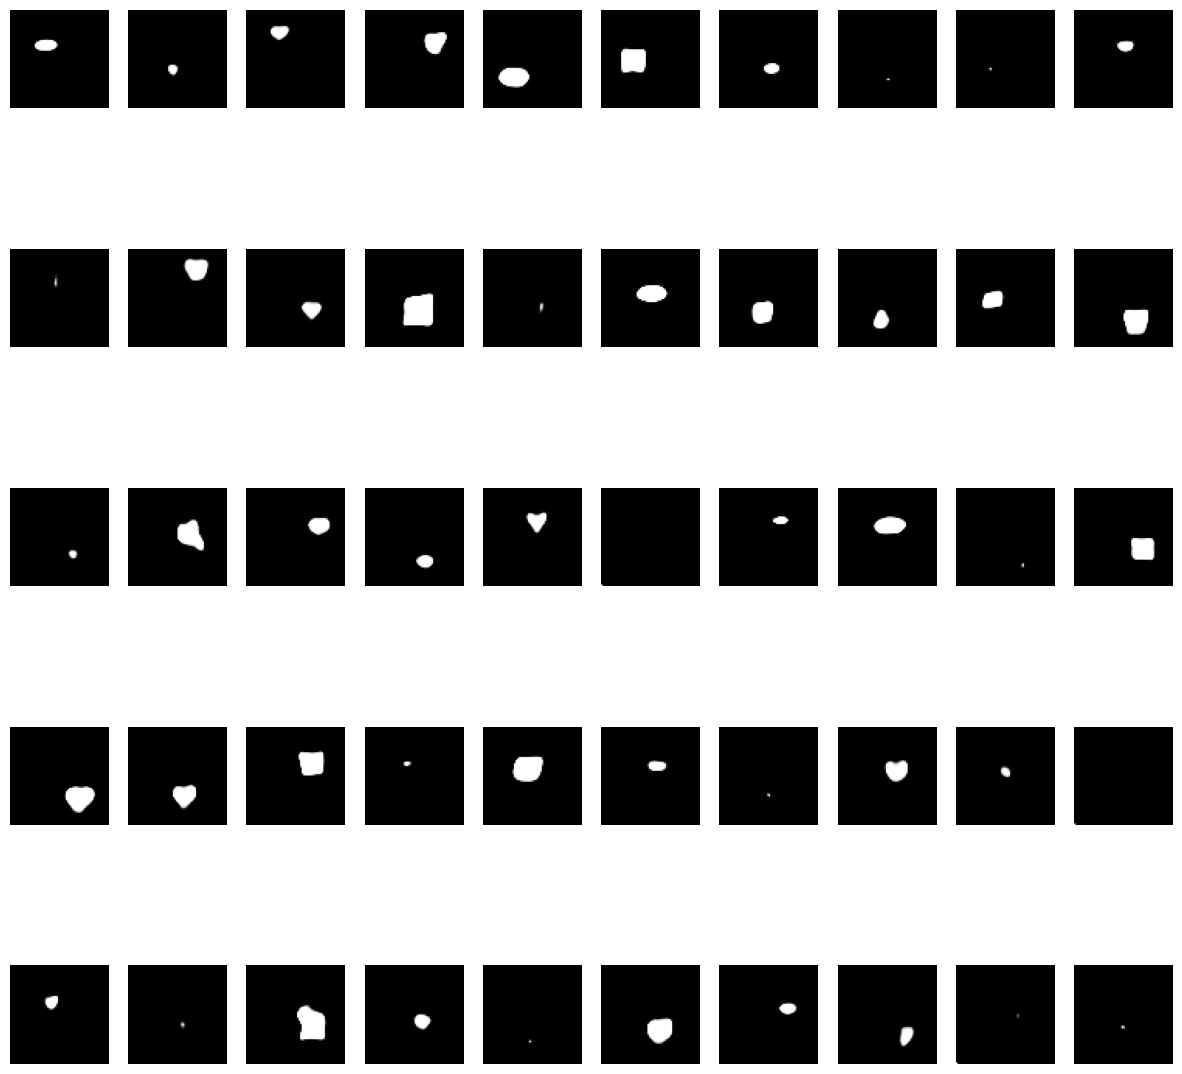

In [29]:
# generate images
#Generate 50 images, each image provide a vector of size 10 as input
latent_points = generate_latent_points(10, 50)
# generate images
X = vae.decoder.predict(latent_points)
# plot the result
save_plot(X, 5 , 10)

In [45]:
class ControlVAE(tf.keras.Model):
    def __init__(self,  **kwargs):
        super(ControlVAE, self).__init__(**kwargs)
        # Define encoder, decoder, z_mean, z_log_var layers

        # encoder
        self.encoder = tf.keras.Sequential([
            Input(shape=input_shape),
            Conv2D(32, (4, 4), activation='relu', strides=2, padding='same'),
            Conv2D(32, (4, 4), activation='relu', strides=2, padding='same'),
            Conv2D(64, (4, 4), activation='relu', strides=2, padding='same'),
            Conv2D(64, (4, 4), activation='relu', strides=2, padding='same'),
            Conv2D(256, (4, 4), activation='relu', padding='same'),
            Flatten(),
            Dense(256, activation="relu"),
            Dense(20, activation="relu"),
            # Dense(latent_dim),
        ])

        # reparameterization/sampling layer
        self.z_mean = Dense(latent_dim, name="z_mean")
        self.z_log_var = Dense(latent_dim, name="z_log_var")

        # decoder
        self.decoder = tf.keras.Sequential([
            Input(shape=(latent_dim,)),
            Dense(256, activation='relu'),
            Reshape((4, 4, 16)),  # For the decoder output to be the same size as the encoder input
            Conv2DTranspose(256, (4, 4), activation='relu', strides=1, padding='same'),
            Conv2DTranspose(64, (4, 4), activation='relu', strides=2, padding='same'),
            Conv2DTranspose(64, (4, 4), activation='relu', strides=2, padding='same'),
            Conv2DTranspose(32, (4, 4), activation='relu', strides=2, padding='same'),
            Conv2DTranspose(32, (4, 4), activation='relu', strides=2, padding='same'),
            Conv2DTranspose(1, (4, 4), activation='sigmoid', padding='same', name='decoder_output')
        ])

        # Initialize PID controller parameters
        self.Kp = 0.01
        self.Ki = 0.001
        self.vkl_setpoint = 14 # we change the kl setpoint here
        self.beta_min = 0.0
        self.beta_max = 1.0
        self.beta = 0.0
        self.integral = 0.0

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def encode(self, data):
        x = self.encoder(data)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        return z_mean, z_log_var

    def reparameterization(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z =  z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z

    def decode(self, data):
        return self.decoder(data)

    def _Kp_fun(self, Err, scale=1):
        return 1.0/(1.0 + tf.math.exp(Err))

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        integral_1 = self.integral
        beta = self.beta
        Kp = self.Kp
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encode(data)
            z = self.reparameterization(z_mean, z_log_var)
            reconstruction = self.decode(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.math.square(z_mean) - tf.math.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # Compute PID control
            kl_error = self.vkl_setpoint -  kl_loss
            p_term = Kp * self._Kp_fun(kl_error)+1
            integral = integral_1 + self.Ki * kl_error
            if beta > self.beta_min and beta < self.beta_max:
              integral = integral_1

            # Update beta using PID control
            beta = p_term + integral
            integral_1 = integral
            Kp = p_term
            beta = tf.where(beta > self.beta_max, self.beta_max, beta)
            beta = tf.where(beta < self.beta_min, self.beta_min, beta)

            total_loss = reconstruction_loss +  beta * kl_loss

        # Combined loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


# KL set point is 8

In [35]:
controlvae = ControlVAE()
# Define the learning rate
learning_rate = 0.0001

# Compile the VAE model with the Adam optimizer and the specified learning rate
controlvae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))

In [36]:
history_2 = LossHistory()
controlvae.fit(data, epochs=50, batch_size=32, callbacks=[history_2])

Epoch 1/50
576/576 [==============================] - 12s 10ms/step - loss: 971.2344 - reconstruction_loss: 538.5244 - kl_loss: 11.8348
Epoch 2/50
576/576 [==============================] - 6s 10ms/step - loss: 210.3575 - reconstruction_loss: 172.5697 - kl_loss: 20.8467
Epoch 3/50
576/576 [==============================] - 6s 10ms/step - loss: 134.8885 - reconstruction_loss: 105.0434 - kl_loss: 21.8753
Epoch 4/50
576/576 [==============================] - 6s 10ms/step - loss: 113.1939 - reconstruction_loss: 88.5099 - kl_loss: 21.3647
Epoch 5/50
576/576 [==============================] - 6s 11ms/step - loss: 95.8571 - reconstruction_loss: 68.0435 - kl_loss: 22.6284
Epoch 6/50
576/576 [==============================] - 6s 10ms/step - loss: 80.8155 - reconstruction_loss: 56.2615 - kl_loss: 23.0017
Epoch 7/50
576/576 [==============================] - 6s 11ms/step - loss: 75.3240 - reconstruction_loss: 50.9899 - kl_loss: 22.8950
Epoch 8/50
576/576 [==============================] - 6s 10ms

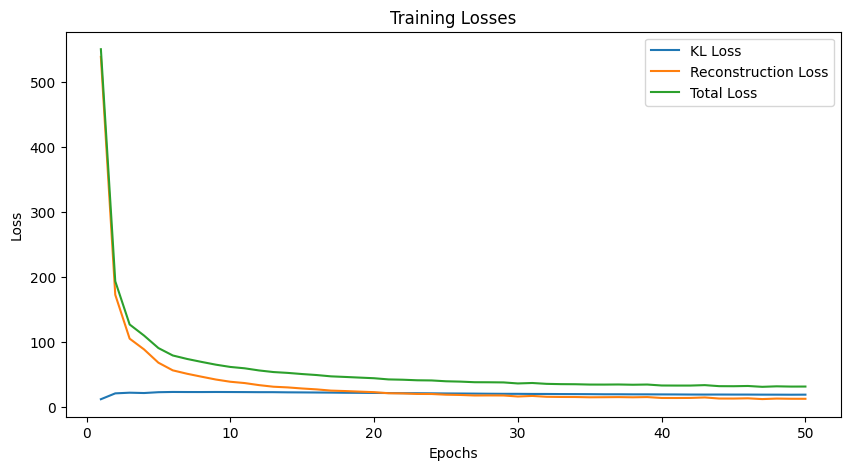

In [37]:
# Plot losses
epochs_range = range(1, 51)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, history_2.kl_losses, label='KL Loss')
plt.plot(epochs_range, history_2.reconstruction_losses, label='Reconstruction Loss')
plt.plot(epochs_range, history_2.total_losses, label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

2/2 [==============================] - 0s 5ms/step


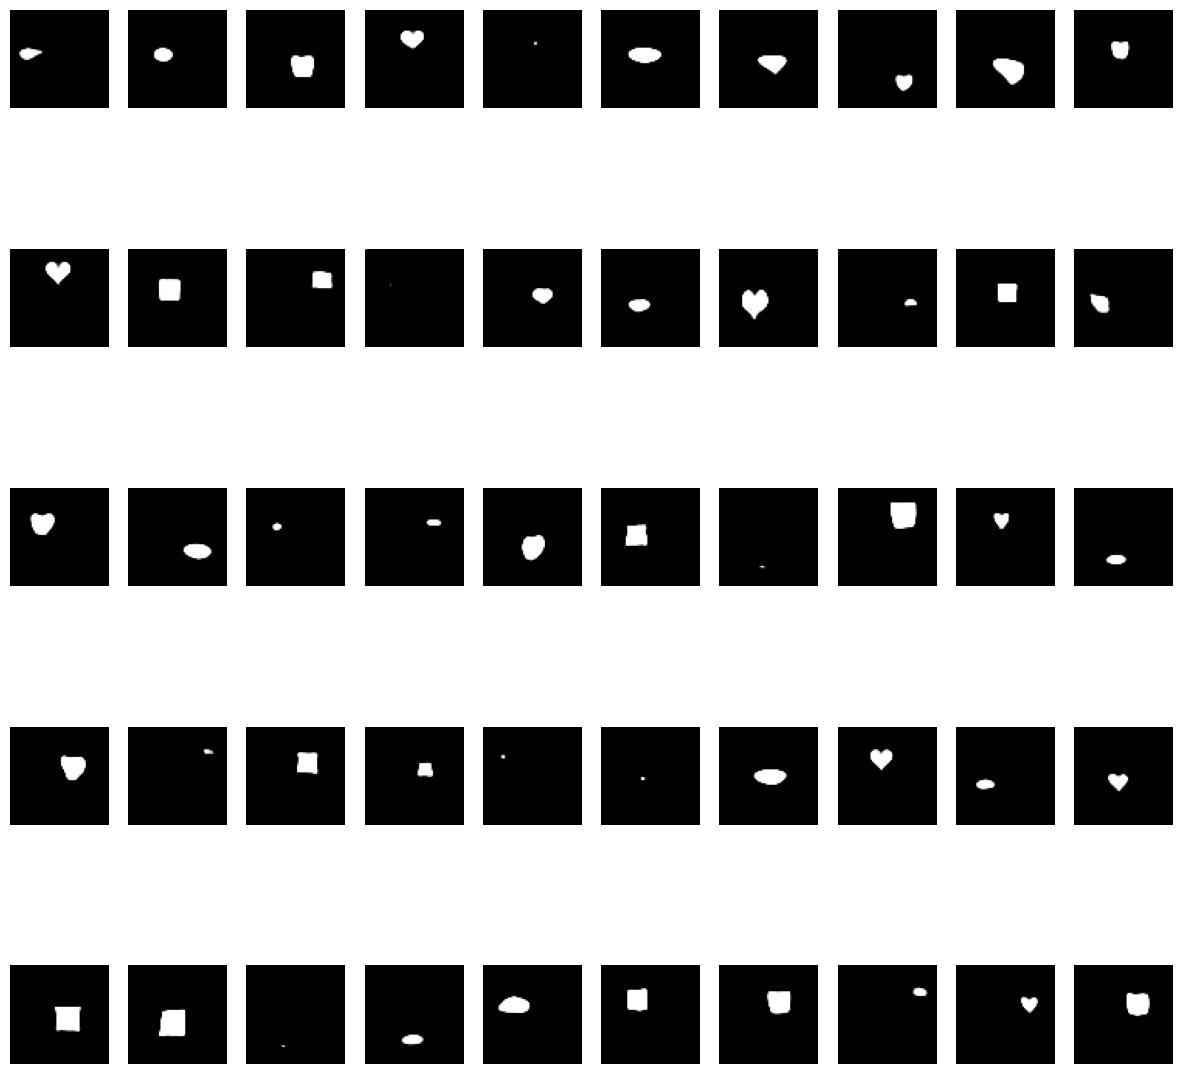

In [38]:
# generate images
latent_points = generate_latent_points(10, 50)
# generate images
X = controlvae.decoder.predict(latent_points)
# plot the result
save_plot(X, 5 , 10)

In [39]:
# Generate 6000 images using your VAE model
latent_points = generate_latent_points(10, 6000)
# generate images
generated_images = controlvae.decoder.predict(latent_points)

32/32 [==============================] - 0s 5ms/step


In [40]:
# Scale generated images to the required input shape (299, 299, 3) for InceptionV3
scaled_generated_images = scale_images(generated_images, (299, 299, 3))

In [42]:
# Calculate FID score
fid_score = calculate_fid(scaled_real_images, scaled_generated_images)
print("FID Score:", fid_score)

32/32 [==============================] - 4s 121ms/step
FID Score: 66.54260988665074


# KL set point is 14

In [49]:
controlvae = ControlVAE()
# Define the learning rate
learning_rate = 0.0001

# Compile the VAE model with the Adam optimizer and the specified learning rate
controlvae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))

In [50]:
history_3 = LossHistory()
controlvae.fit(data, epochs=50, batch_size=32, callbacks=[history_3])

Epoch 1/50
576/576 [==============================] - 11s 11ms/step - loss: 1035.9899 - reconstruction_loss: 541.2784 - kl_loss: 11.1810
Epoch 2/50
576/576 [==============================] - 6s 10ms/step - loss: 145.5543 - reconstruction_loss: 113.7599 - kl_loss: 23.5726
Epoch 3/50
576/576 [==============================] - 6s 10ms/step - loss: 122.0066 - reconstruction_loss: 94.8566 - kl_loss: 23.4269
Epoch 4/50
576/576 [==============================] - 6s 10ms/step - loss: 103.0867 - reconstruction_loss: 72.4482 - kl_loss: 24.9261
Epoch 5/50
576/576 [==============================] - 6s 11ms/step - loss: 85.9362 - reconstruction_loss: 58.3056 - kl_loss: 25.7020
Epoch 6/50
576/576 [==============================] - 6s 10ms/step - loss: 78.1591 - reconstruction_loss: 51.6439 - kl_loss: 25.7827
Epoch 7/50
576/576 [==============================] - 6s 11ms/step - loss: 73.3969 - reconstruction_loss: 46.3890 - kl_loss: 25.9701
Epoch 8/50
576/576 [==============================] - 6s 10ms

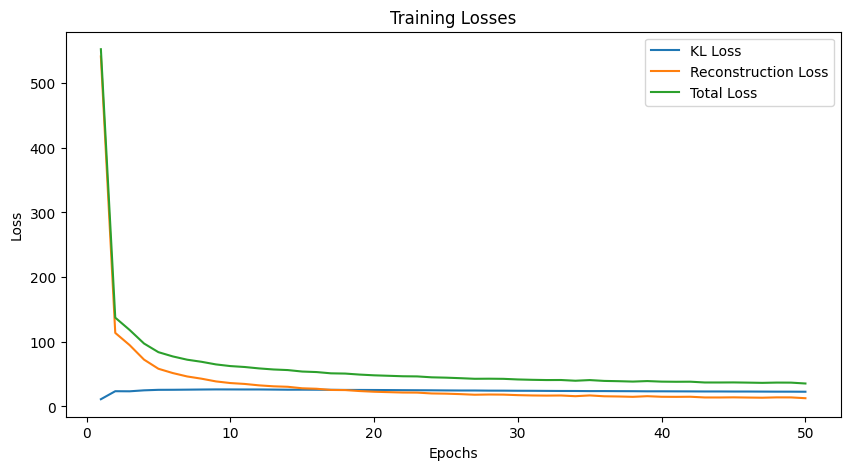

In [52]:
# Plot losses
epochs_range = range(1, 51)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, history_3.kl_losses, label='KL Loss')
plt.plot(epochs_range, history_3.reconstruction_losses, label='Reconstruction Loss')
plt.plot(epochs_range, history_3.total_losses, label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

2/2 [==============================] - 0s 5ms/step


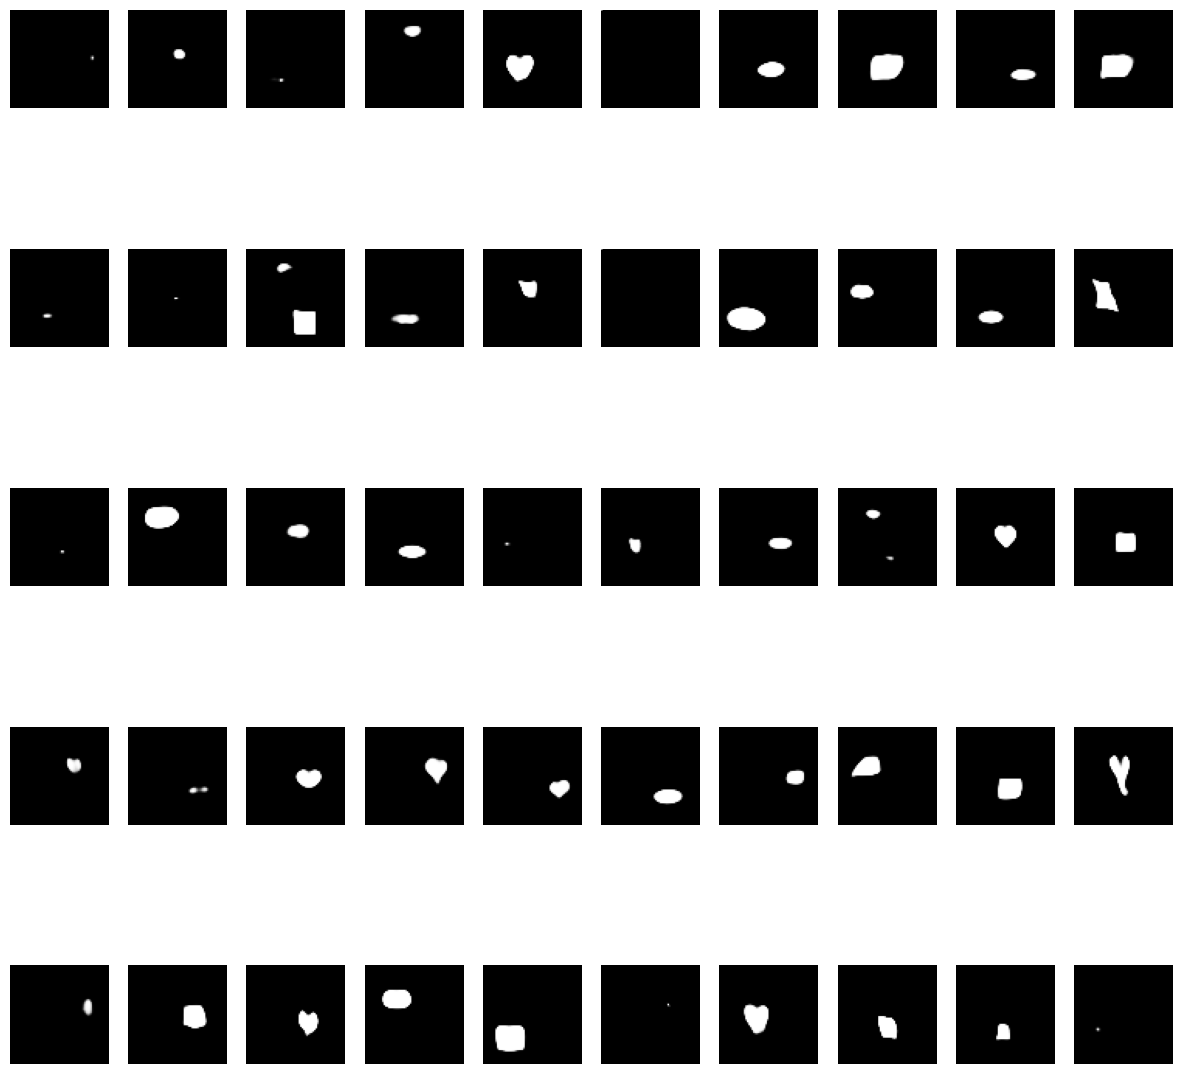

In [53]:
# generate images
latent_points = generate_latent_points(10, 50)
# generate images
X = controlvae.decoder.predict(latent_points)
# plot the result
save_plot(X, 5 , 10)

In [54]:
# Generate 6000 images using your VAE model
latent_points = generate_latent_points(10, 6000)
# generate images
generated_images = controlvae.decoder.predict(latent_points)

32/32 [==============================] - 0s 4ms/step


In [55]:
# Scale generated images to the required input shape (299, 299, 3) for InceptionV3
scaled_generated_images = scale_images(generated_images, (299, 299, 3))

In [56]:
# Calculate FID score
fid_score = calculate_fid(scaled_real_images, scaled_generated_images)
print("FID Score:", fid_score)

32/32 [==============================] - 4s 114ms/step
FID Score: 69.91322256831593


# We compare KL setpoints 8 and 14

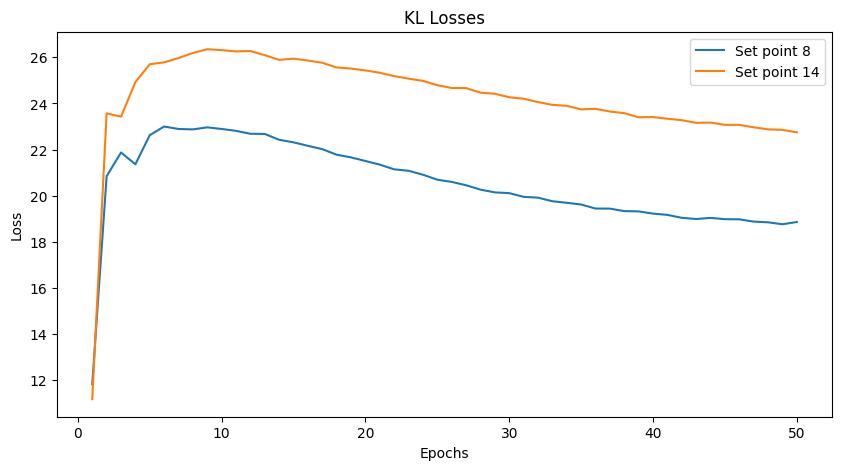

In [57]:
# Plot losses
epochs_range = range(1, 51)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, history_2.kl_losses, label='Set point 8')
plt.plot(epochs_range, history_3.kl_losses, label='Set point 14')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('KL Losses')
plt.legend()
plt.show()

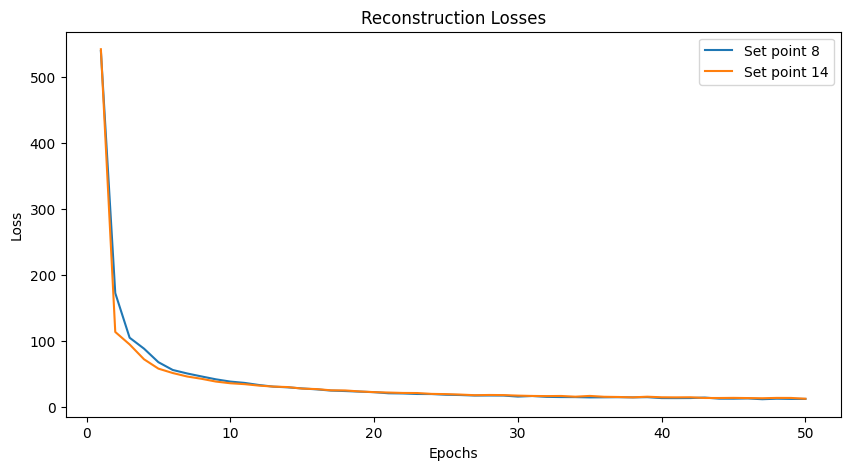

In [58]:
# Plot losses
epochs_range = range(1, 51)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, history_2.reconstruction_losses, label='Set point 8')
plt.plot(epochs_range, history_3.reconstruction_losses, label='Set point 14')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Losses')
plt.legend()
plt.show()

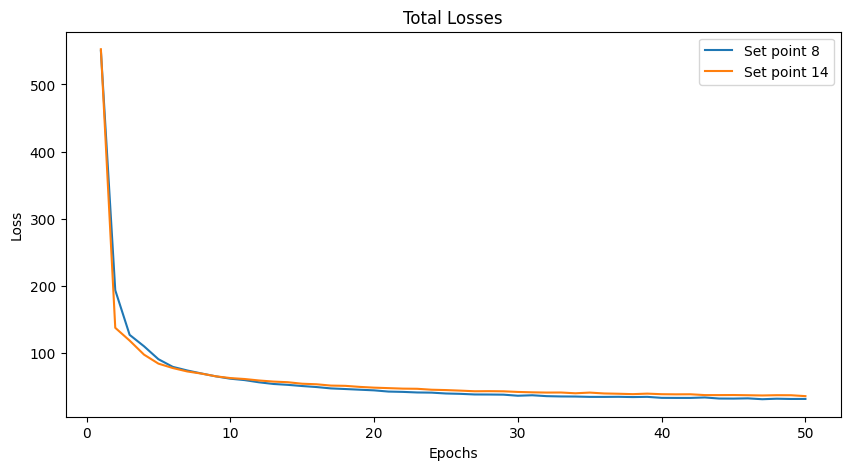

In [59]:
# Plot losses
epochs_range = range(1, 51)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, history_2.total_losses, label='Set point 8')
plt.plot(epochs_range, history_3.total_losses, label='Set point 14')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Total Losses')
plt.legend()
plt.show()

# Compare all 3 models KL loss

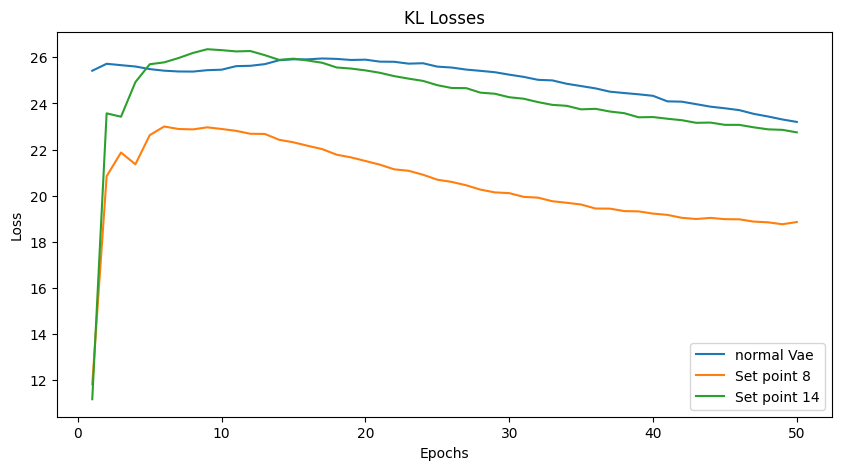

In [60]:
# Plot losses
epochs_range = range(1, 51)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, history_1.kl_losses, label='normal Vae')
plt.plot(epochs_range, history_2.kl_losses, label='Set point 8')
plt.plot(epochs_range, history_3.kl_losses, label='Set point 14')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('KL Losses')
plt.legend()
plt.show()